<h1> Assignment 3: Group Project </h1>

In [36]:
# import libraries

import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import re

##**1. Data preparation and exploration**

###**1.1 Data Retrieving**

In [37]:
movies_df = pd.read_csv('data/movies.csv', delimiter=',')
ratings_df = pd.read_csv('data/ratings.csv', delimiter=',')

C:\Users\paull\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [38]:
movies_df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [39]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


###**1.2 Data cleaning and preparation**

In [40]:
# Create orginal data frame for backup
movies_df_raw = movies_df.copy()
ratings_df_raw = ratings_df.copy()

In [41]:
#set threshold
threshold = 0.65

# dropping columns with missing value rate higher than threshold
ratings_df = ratings_df[ratings_df.columns[ratings_df.isnull().mean() < threshold]]

# Remove the missing values from the rows having greater or equal to 6 missing values.
movies_df = movies_df[movies_df.isnull().sum(axis=1) <= 6]
ratings_df = ratings_df[ratings_df.isnull().sum(axis=1) <= 6]

####**1.2.1 Handle missing data**

In [42]:
# Filling missing value for movies dataset

movies_df["tagline"] = movies_df["tagline"].fillna("Unknown")

movies_df["overview"] = movies_df["overview"].fillna("Unknown")

movies_df["poster_path"] = movies_df["poster_path"].fillna("Unknown")

movies_df["runtime"] = movies_df["runtime"].fillna(method='ffill')

movies_df["release_date"] = movies_df["release_date"].fillna(method='ffill')

movies_df["status"] = movies_df["status"].fillna(movies_df['status'].mode()[0])

movies_df["imdb_id"] = movies_df["imdb_id"].fillna("imdb_id")

movies_df["original_language"] = movies_df["original_language"].fillna(movies_df['original_language'].mode()[0])

In [43]:
# Movies dataset
percent_missing = movies_df.isnull().sum() * 100 / len(movies_df)
missing_values = pd.DataFrame({'percent_missing': percent_missing})
missing_values.sort_values(by ='percent_missing' , ascending=False)

,percent_missing
belongs_to_collection,90.121447
homepage,82.887442
adult,0.000000
production_countries,0.000000
vote_average,0.000000
video,0.000000
title,0.000000
tagline,0.000000
status,0.000000
spoken_languages,0.000000


####**1.2.2 Data encoding**

Convert column 'belongs_to_collection' data to binary data of 0 and 1 (1 means the movie belongs to a collection, and 0 means it does not belong to any collection)

In [44]:
# converting column 'belongs_to_collection' to binary 0 and 1 data
movies_df["belongs_to_collection"] = movies_df["belongs_to_collection"].fillna(0)
movies_df["belongs_to_collection"] = np.where(movies_df["belongs_to_collection"] != 0,1,0)
movies_df['belongs_to_collection'] = pd.to_numeric(movies_df['belongs_to_collection'])

Convert column 'homepage' to binary data of 0 and 1 (1 means the movie has a homepage, and 0 means the movie does not have a homepage)

In [45]:
movies_df["homepage"] = movies_df["homepage"].fillna(0)
movies_df["homepage"] = np.where(movies_df["homepage"] != 0,1,0)
movies_df['homepage'] = pd.to_numeric(movies_df['homepage'])

Convert column 'adult' data from boolean value to 1 and 0 (1: True, 0: False)

In [46]:
movies_df["adult"] = np.where(movies_df['adult'] == True, 1, 0)
movies_df['adult'] = pd.to_numeric(movies_df['adult'])

In [47]:
# Ratings dataset
percent_missing = ratings_df.isnull().sum() * 100 / len(ratings_df)
missing_values = pd.DataFrame({'percent_missing': percent_missing})
missing_values.sort_values(by ='percent_missing' , ascending=False)

,percent_missing
userId,0.0
movieId,0.0
rating,0.0
timestamp,0.0


In [48]:
# rename column id in movies_df to match movieId with ratings_df
movies_df.rename(columns={"id": "movieId"}, inplace=True)

In [49]:
# Check type for movies_df
movies_df.dtypes

adult                      int32
belongs_to_collection      int32
budget                    object
genres                    object
homepage                   int32
movieId                   object
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity                object
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
video                     object
vote_average             float64
vote_count               float64
dtype: object

In [50]:
# Check type for ratings_df
ratings_df.dtypes

userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object

In [51]:
# Delete row in movieId column contain string value
movies_df = movies_df[~movies_df['movieId'].isin(['1997-08-20', '2012-09-29','2014-01-01'])]

In [52]:
# change column type for movies_df
movies_df["movieId"] = pd.to_numeric(movies_df["movieId"])

movies_df['popularity'] = movies_df['popularity'].astype(float)

movies_df['budget'] = movies_df['budget'].astype(float)

In [53]:
ratings_df = ratings_df.groupby(['movieId']).mean().groupby('movieId')['rating'].mean().reset_index()

In [54]:
df = movies_df.merge(ratings_df, how="left", on="movieId")

comment_counts = pd.DataFrame(df["title"].value_counts())
rare_movies = comment_counts[comment_counts["title"] <= 1000].index
common_movies = df[~df["title"].isin(rare_movies)]

In [55]:
from ast import literal_eval

def split_genres(row):
    row['genres'] = ",".join([info['name'] for info in literal_eval(row['genres'])])
    return row

def split_prod_countries(row):
    row['production_countries'] = ",".join([info['name'] for info in literal_eval(row['production_countries'])])
    return row

def split_prod_companies(row):
    row['production_companies'] = ",".join([info['name'] for info in literal_eval(row['production_companies'])])
    return row

def split_spoken_languages(row):
    row['spoken_languages'] = ",".join([info['name'] for info in literal_eval(row['spoken_languages'])])
    return row
  
df = df.apply(split_genres, axis=1)
df = df.apply(split_prod_countries, axis=1)
df = df.apply(split_prod_companies, axis=1)
df = df.apply(split_spoken_languages, axis=1)

KeyboardInterrupt: 

In [ ]:
# function for text cleaning
def clean_text(text):
    # remove backslash-apostrophe
    text = re.sub("\'", "", text)
    # remove everything alphabets
    text = re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)
    # remove whitespaces
    text = ' '.join(text.split())
    # remove double quote inside
    text = text.replace('“', '').replace('”', '').replace('"', '')
    # remove number
    text = re.sub(r"\d+", "", text)
    # convert text to lowercase
    text = text.lower()
    
    return text

In [ ]:
# Apply clean_text function for cleaning text
df['title'] = df['title'].apply(lambda x: clean_text(x))
df['tagline'] = df['tagline'].apply(lambda x: clean_text(x))
df['original_title'] = df['original_title'].apply(lambda x: clean_text(x))
df['overview'] = df['overview'].apply(lambda x: clean_text(x))

In [24]:
# Remove stopword
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)
  
df['overview'] = df['overview'].apply(lambda x: remove_stopwords(x))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\paull\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
category_list = []
for value in df['genres'].unique():
  value_list = value.split(',')
  for item in value_list:
    category_list.append(item)

category_list = np.unique(np.array(category_list)).tolist()
category_list.remove("")
print(category_list)

['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western']


In [26]:
for category in category_list:
  column_name = 'genres_' + category
  df[column_name] = np.where(df['genres'].str.contains(category), 1, 0)
df.head()

,adult,belongs_to_collection,budget,genres,homepage,movieId,imdb_id,original_language,original_title,overview,...,genres_History,genres_Horror,genres_Music,genres_Mystery,genres_Romance,genres_Science Fiction,genres_TV Movie,genres_Thriller,genres_War,genres_Western
0,0,1,30000000.0,"Animation,Comedy,Family",1,862,tt0114709,en,toy story,led woody andys toys live happily room andys b...,...,0,0,0,0,0,0,0,0,0,0
1,0,0,65000000.0,"Adventure,Fantasy,Family",0,8844,tt0113497,en,jumanji,siblings judy peter discover enchanted board g...,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0.0,"Romance,Comedy",0,15602,tt0113228,en,grumpier old men,family wedding reignites ancient feud nextdoor...,...,0,0,0,0,1,0,0,0,0,0
3,0,0,16000000.0,"Comedy,Drama,Romance",0,31357,tt0114885,en,waiting to exhale,cheated mistreated stepped women holding breat...,...,0,0,0,0,1,0,0,0,0,0
4,0,1,0.0,Comedy,0,11862,tt0113041,en,father of the bride part ii,george banks recovered daughters wedding recei...,...,0,0,0,0,0,0,0,0,0,0


###**1.3 Data Exploration**

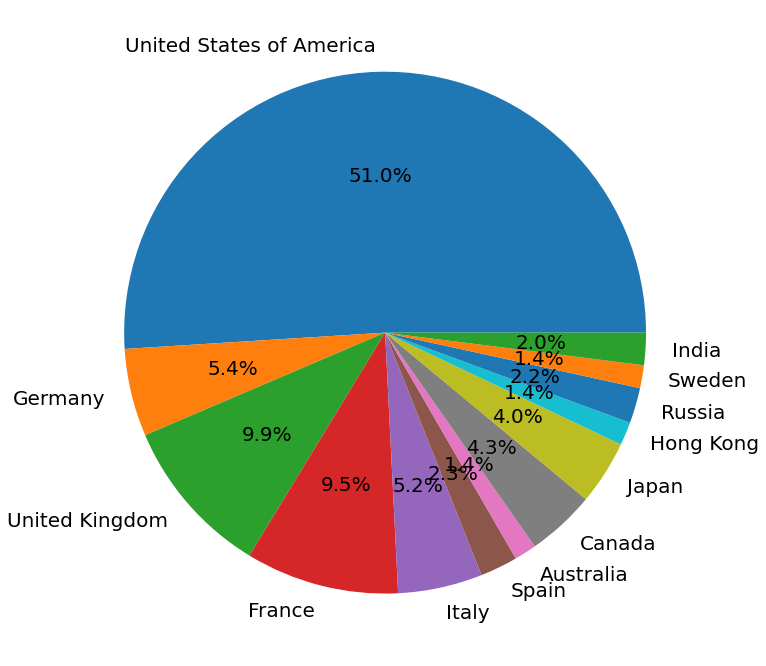

In [27]:
from collections import Counter

a=[]
for each in df.production_countries.str.split(","):
    for i in each:
        a.append(i)
        
b = dict(Counter(a))

keys=[]
values=[]

for key,value in b.items() :
    if value > 500 and key != "":
        keys.append(key)
        values.append(value)

       
labels = keys
colors = sns.color_palette()
explode =[0,0,0,0,0,0,0,0,0,0,0,0,0]
sizes= values
    
plt.figure(figsize = (20,12))

plt.pie(sizes,explode = explode,labels=labels,colors = colors,autopct='%1.1f%%',textprops= {"fontsize": 20},shadow = False)

plt.show()

Text(0.5, 1.0, 'Number of movie types')

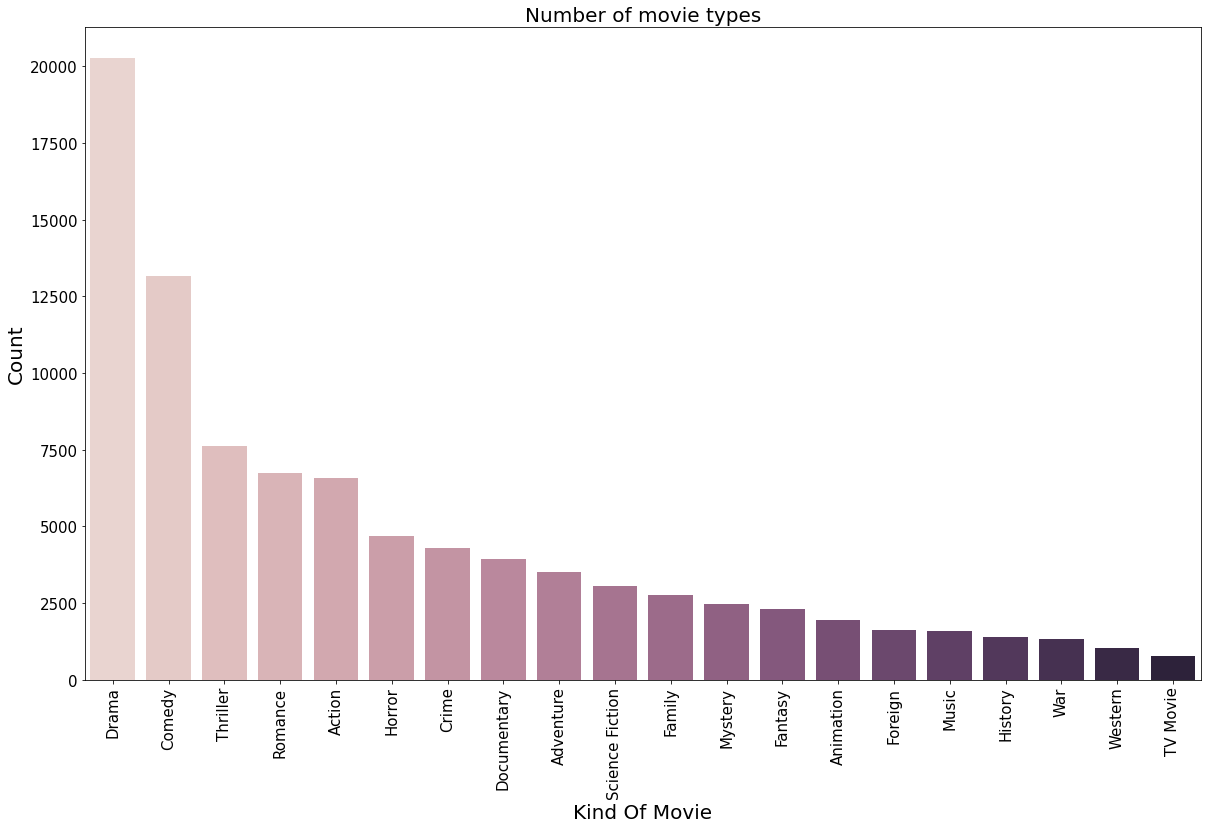

In [28]:
from collections import Counter

data = df.genres.copy()

list_kind = data.str.split(",")
a = []
for each in list_kind:
    for i in each:
        a.append(i)
        
c=[]
for each in a:
    if each != "":
         c.append(each)        
        
f= dict(Counter(c))

df3 = pd.DataFrame(list(f.items()),columns = ["kind","ratio"])
new_index =( df3.ratio.sort_values(ascending=False)).index.values
new = df3.reindex(new_index)

plt.figure( figsize = (20,12))
plt.tick_params(labelsize = 15)
sns.barplot(x="kind",y="ratio",data=new,palette = sns.cubehelix_palette(len(f)))
plt.xticks(rotation = 90)
plt.xlabel("Kind Of Movie",fontsize=20)
plt.ylabel("Count",fontsize=20)
plt.title("Number of movie types",fontsize = 20)

C:\Users\paull\AppData\Local\Temp/ipykernel_22016/2533671194.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([num for num in ax.get_yticks()])


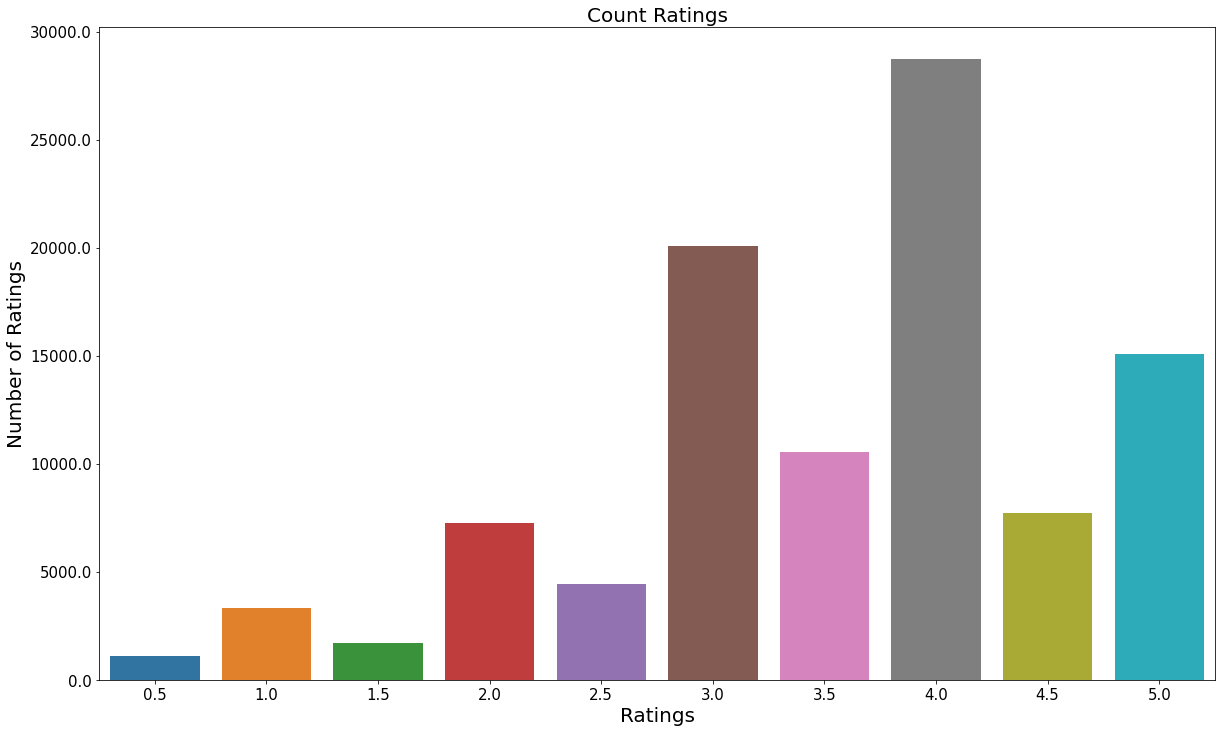

In [29]:
f,ax = plt.subplots(1,1,figsize=(20,12))
ax = sns.countplot(x="rating", data=ratings_df_raw)
ax.set_yticklabels([num for num in ax.get_yticks()])
plt.tick_params(labelsize = 15)
plt.title("Count Ratings", fontsize = 20)
plt.xlabel("Ratings", fontsize = 20)
plt.ylabel("Number of Ratings", fontsize = 20)
plt.show()

Text(0.5, 1.0, 'Popular Movies')

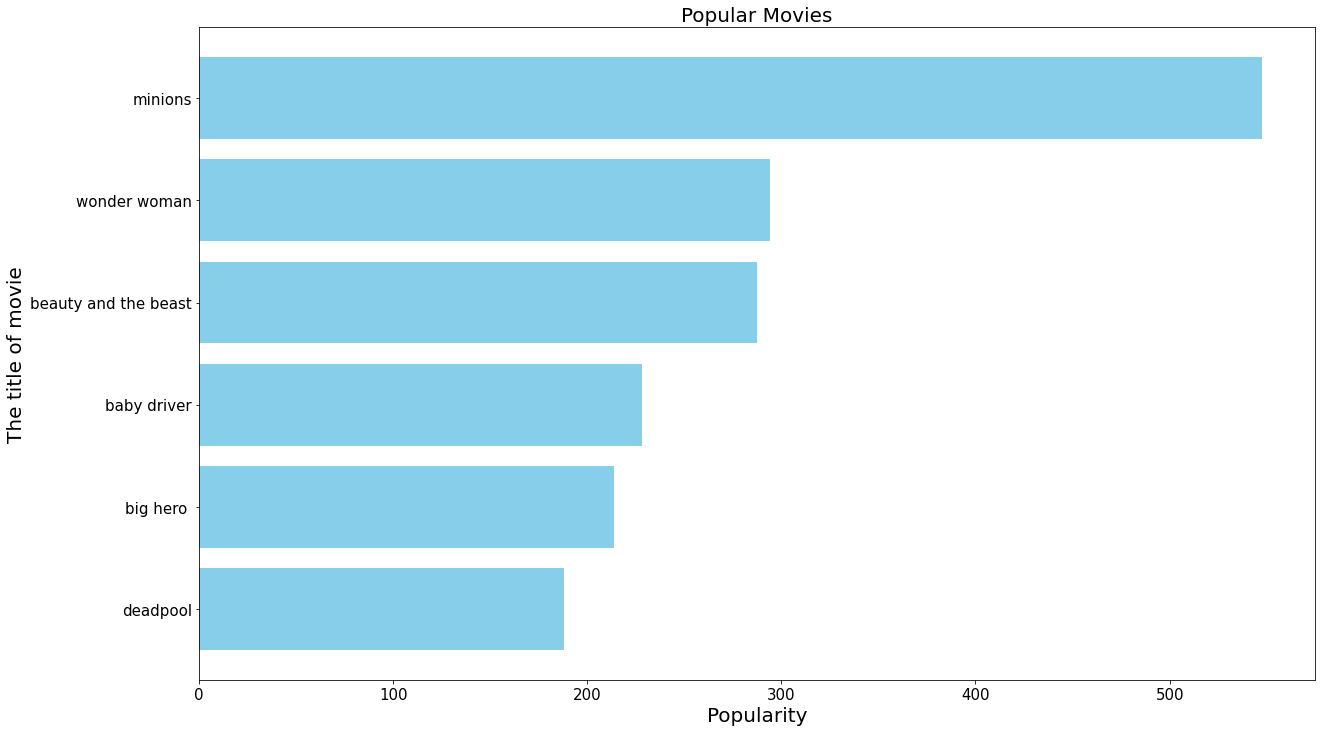

In [30]:
pop = df.sort_values('popularity', ascending=False)
plt.figure(figsize=(20,12))

plt.barh(pop['title'].head(6),pop['popularity'].head(6), align='center',
        color='skyblue')
plt.gca().invert_yaxis()
plt.tick_params(labelsize = 15)
plt.xlabel("Popularity", fontsize = 20)
plt.ylabel("The title of movie", fontsize = 20)
plt.title("Popular Movies", fontsize = 20)

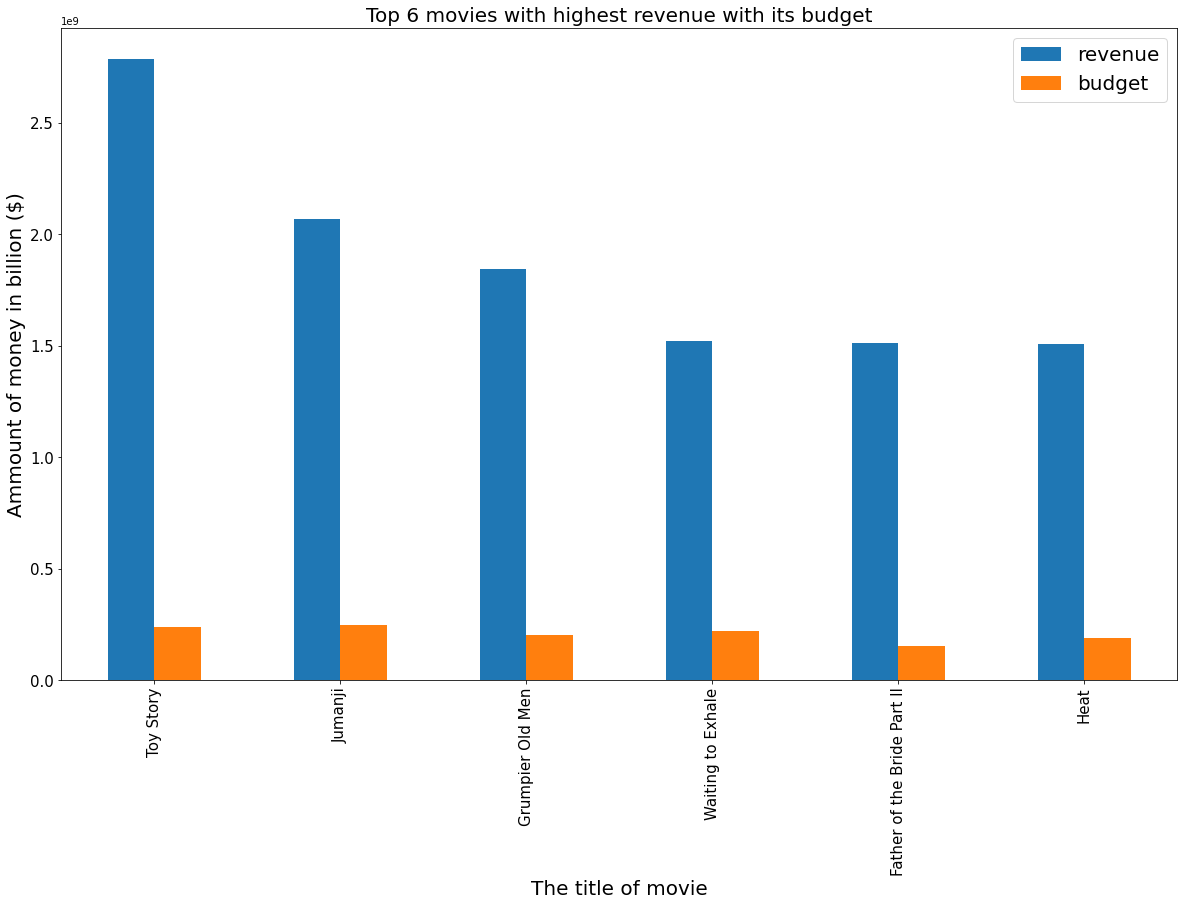

In [31]:
df1 = movies_df[['title','revenue','budget']].copy()

df1.set_index('title', inplace=True)

ax = df1.sort_values(by=['revenue'], ascending=False).head(6).plot(kind='bar', figsize=(20,12))
ax.xaxis.set_major_formatter(plt.FixedFormatter(df1.index.to_series()))
plt.tick_params(labelsize = 15)
plt.ylabel("Ammount of money in billion ($)", fontsize = 20)
plt.xlabel("The title of movie", fontsize = 20)
plt.legend(fontsize=20)
plt.title("Top 6 movies with highest revenue with its budget", fontsize = 20)
plt.show()

Text(0.5, 1.0, 'Most popular language in movies')

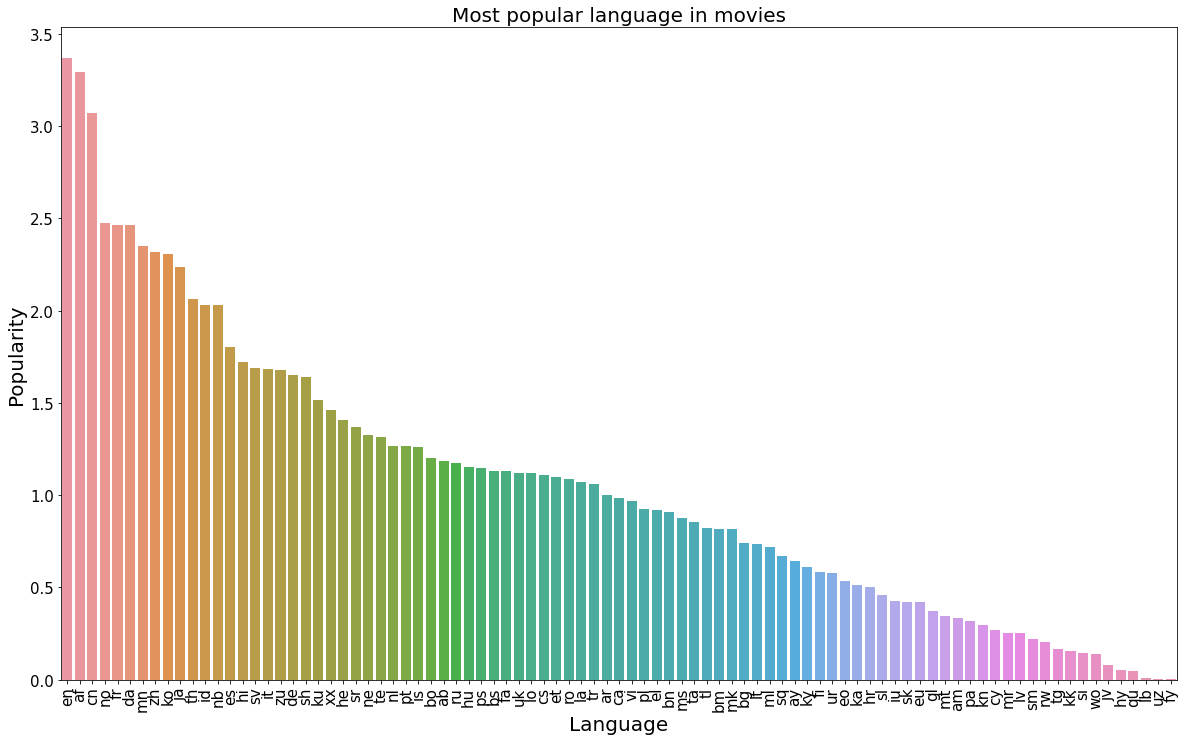

In [32]:
unique = list(movies_df.original_language.unique())
list_ratio=[]
for each in unique:
    x= movies_df[movies_df["original_language"] == each]
    ratio_popularity=sum(x.popularity)/len(x)
    list_ratio.append(ratio_popularity)
    
df1 = pd.DataFrame({"language":unique,"ratio":list_ratio})
new_index = (df1.ratio.sort_values(ascending = False)).index.values
sorted_data= df1.reindex(new_index)

#Visualization
plt.figure(figsize = (20,12))
sns.barplot(x= sorted_data["language"],y  = sorted_data["ratio"])
plt.xticks(rotation= 90)
plt.tick_params(labelsize = 15)

plt.xlabel("Language",fontsize = 20)
plt.ylabel("Popularity",fontsize = 20)
plt.title("Most popular language in movies", fontsize = 20)

##**2. Data Modelling**

###**2.1 Feature Engineering**

####**2.1.1 Reasoning**

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45452 entries, 0 to 45451
Data columns (total 45 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   adult                   45452 non-null  int64  
 1   belongs_to_collection   45452 non-null  int64  
 2   budget                  45452 non-null  float64
 3   genres                  45452 non-null  object 
 4   homepage                45452 non-null  int64  
 5   movieId                 45452 non-null  int64  
 6   imdb_id                 45452 non-null  object 
 7   original_language       45452 non-null  object 
 8   original_title          45452 non-null  object 
 9   overview                45452 non-null  object 
 10  popularity              45452 non-null  float64
 11  poster_path             45452 non-null  object 
 12  production_companies    45452 non-null  object 
 13  production_countries    45452 non-null  object 
 14  release_date            45452 non-null

####**2.1.2 Correlation Matrix**

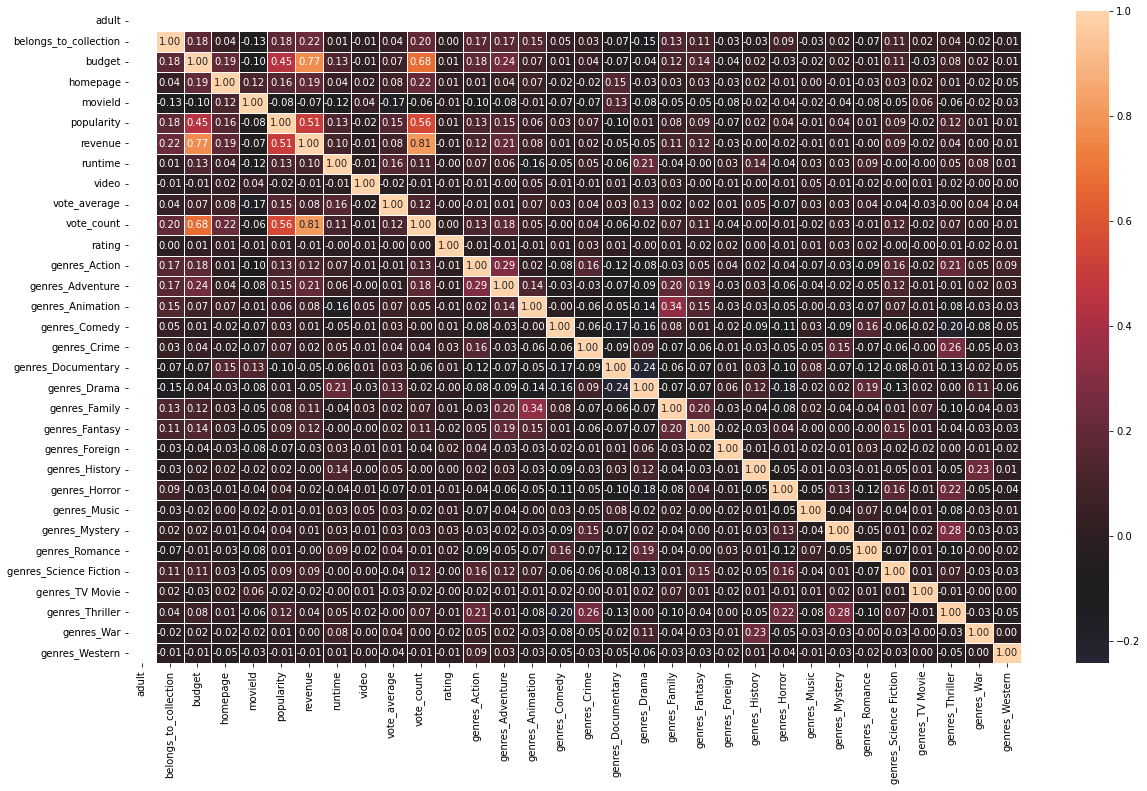

In [34]:
f,ax = plt.subplots(figsize = (20,12))
sns.heatmap (df.corr(), annot = True,linewidths =0.75,linecolor = "White",fmt = ".2f",ax = ax,center = -0.1)
plt.show()

###**2.2 K-fold cross validation**

In [35]:
from sklearn.model_selection import KFold

kf5 = KFold(n_splits=5, shuffle=False)

###**2.3 Parameter tuning**

###**2.4 Model training**

###**2.5 Model Evaluation and Selection**

###**2.6 Save the model for deployment**

In this task, we use Pickle to save and load the model. Since in order to use the model outside of the notebook, we need to sae it - and then later, we can load and use it for deployment 

In [37]:
import pickle

# pickle.dump(model1, open('model1.pkl', 'wb'))
# pickle.dump(model2, open('model2.pkl', 'wb'))
# pickle.dump(model3, open('model3.pkl', 'wb'))

##**3. Model deployment and Automation**

##**4. Visualisation Dashboard**

Please refer to the readme.txt file in the root directory to run the visualisation dashboard.